<a href="https://colab.research.google.com/github/ivanpicavet/automatic__offensive_speech_detection/blob/main/Main_hate_speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tweepy
import re
import pickle
import os
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
tsv_file=pd.read_csv("./task_a_distant.tsv",sep="\t")

# Test on bigger and more balanced dataset

In [ ]:
tsv_file.shape

(1048966, 3)

In [ ]:
sample_test=tsv_file.sample(200000)

In [ ]:
with open("sample_test","wb") as f:
  pickle.dump(sample_test,f)

In [ ]:
sample_test.head()

,id,average,std
112280,1160726189406863360,0.308960,0.248601
530960,1161492686584594439,0.126178,0.145746
913705,1160091638255034368,0.211478,0.178150
838608,1159274365961277443,0.371133,0.172761
462833,1160689079253708802,0.379854,0.112563


In [ ]:
def is_off2(n):
  if n>0.6:
    return 1
  else:
    return 0  

In [ ]:
sample_test["is_off"]=sample_test["average"].apply(is_off2)

In [ ]:
sample_test_off=sample_test[sample_test["is_off"]==1].sample(50000)
sample_test_noff=sample_test[sample_test["is_off"]==0].sample(80000)

In [ ]:
frames=[sample_test_off,sample_test_noff]
sample_final_bal=pd.concat(frames)

In [ ]:
with open("sample_final_bal","wb") as f:
  pickle.dump(sample_final_bal,f)

# initializing, tweet fetching and tweet cleanup-tokenize-lemmatize-stopwords


In [ ]:
with open("model_picle","wb") as f:
  pickle.dump(tsv_file,f)

In [ ]:
with open("model_picle","rb") as f:
  dataset=pickle.load(f)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.download("final_file")

In [ ]:
dataset

,id,average,std
0,1159533701283352576,0.195773,0.187379
1,1159533703522992128,0.262401,0.145998
2,1159533703758061570,0.833391,0.140628
3,1159533703904800769,0.565238,0.187498
4,1159533705125343232,0.664921,0.097098
...,...,...,...
2951379,1160000991099441153,0.712557,0.152965
2951380,1160000991070081024,0.277447,0.189987
2951381,1160000991112175616,0.155279,0.169324
2951382,1160000991208583168,0.221621,0.181829


In [ ]:
access_token = "1149046770552451074-hXEspKpCzdBP8ROAoiWwwPwnn5UqG4" 
access_token_secret = "pPupHghLCY3jq4Cx38eOa4vbEjSh8ByZWV2Ppa7E0ODR0"
consumer_key = "FHs90vhXRxbZnjkYk7AwZYMfi" 
consumer_secret = "6pD0XMkTW1BJaO7ACc6bwgmws21jBYYeMQpGFIdMipuVPuoyvk"

In [ ]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret) 
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,retry_count=10, retry_delay=5, retry_errors=set([503]))

In [ ]:
tsv_file_sample=dataset[40:100000]

In [ ]:
ids = tsv_file_sample['id'].tolist()
len(ids)


99960

In [ ]:
total_count = len(ids)
chunks = (total_count - 1) // 50 + 1

In [ ]:
#def fetch_tw(ids):
##    list_of_tw_status = api.statuses_lookup(ids)
#    empty_data = pd.DataFrame()
#    for status in list_of_tw_status:
#            tweet_elem = {"tweet":status.full_text,"id":str(status.id)}
#                    
#            empty_data = empty_data.append(tweet_elem, ignore_index = True)
 #   empty_data.to_csv("final_results2.csv", mode="a")

In [ ]:
#for i in range(chunks):
#        batch = ids[i*50:(i+1)*50]
#        
#        result = fetch_tw(batch)

In [ ]:
try3=pd.read_csv("./final_results2.csv")

In [ ]:
with open("after_fetching_id","wb") as f:
  pickle.dump(try3,f)

In [ ]:
with open("after_fetching_id","rb") as f:
  tweet_with_id=pickle.load(f)

In [ ]:
try3

In [ ]:
try3.drop("Unnamed: 0",axis=1,inplace=True)

In [ ]:
def find_id(s):
    if s=="id":
        s=1
    return s

try3["id"]=try3["id"].apply(find_id)

In [ ]:
for i in range(len(try3["id"])):
    try3["id"].iloc[i]=int(try3["id"].iloc[i])
  

In [ ]:
inner_join = pd.merge(try3,  
                      tsv_file_sample,  
                      on ='id',  
                      how ='inner') 
final_file=inner_join

In [ ]:
final_file

,id,tweet,average,std
0,1159529199708717056,@tribelaw And cut a commercial for his campaign.,0.238702,0.165998
1,1159533793998442498,@IKinosen He sets his phone down and leaves th...,0.241634,0.141148
2,1159533790311505921,:33 &lt; *she grabs his hand* https://t.co/ea6...,0.198585,0.174670
3,1159533747190059008,@bright_heavens @ImohUmoren His own top 10. Yo...,0.267540,0.214426
4,1159533794208157697,@TVietor08 @DeathCar72 Nobody wants his crimes...,0.426871,0.106795
...,...,...,...,...
72593,1160722927395966977,@Bajdaj In The Heat of The Night on.,0.221350,0.129788
72594,1159692445459931136,Dude me all the time... And that its teaching ...,0.287457,0.140963
72595,1159655627129577472,I be doing things for niggas that niggas woul...,0.677585,0.266540
72596,1159692445791215616,😂😂 Serious Question Wig Wearers Have Your Bonn...,0.264426,0.160340


In [ ]:
final_file.describe()

,average,std
count,72598.000000,72598.000000
mean,0.319657,0.169865
std,0.188565,0.037834
min,0.048023,0.003044
25%,0.190799,0.150872
50%,0.246242,0.173307
75%,0.376986,0.189773
max,0.931222,0.394361


In [ ]:
#--------------------------------------------ML---------------------------------------------------------------------

In [ ]:
def text_prep(s):
  s=re.sub("@\S+|http\S+|[^a-z\s]"," ",s.lower())  
  



In [ ]:
def clean_up(s):
    return re.sub("@\S+|http\S+|[^a-z\s]"," ",s.lower())  

In [ ]:
final_file["clean"]=final_file["tweet"].apply(clean_up)

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

In [ ]:
punkt=nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def tokenizer_and_remove_punctuation(row):
    tokens = word_tokenize(row['clean'])
    return [word.lower() for word in tokens if word.isalpha()]

final_file['tokenized'] = final_file.apply(tokenizer_and_remove_punctuation,axis=1)


In [ ]:
wordnet=nltk.download('wordnet') 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
av_percept_tagger=nltk.download('averaged_perceptron_tagger')
lemmatizer = WordNetLemmatizer() 

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper() # gets first letter of POS categorization
    tag_dict = {"J": wordnet.ADJ, 
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN) 

In [ ]:
def lemmatizer_with_pos(row):   
    return [lemmatizer.lemmatize(word,get_wordnet_pos(word)) for word in row['tokenized']]



In [ ]:
final_file["lemmatized"]=final_file.apply(lemmatizer_with_pos,axis=1)

In [ ]:
final_file.head()

,id,tweet,average,std,clean,tokenized,lemmatized
0,1159529199708717056,@tribelaw And cut a commercial for his campaign.,0.238702,0.165998,and cut a commercial for his campaign,"[and, cut, a, commercial, for, his, campaign]","[and, cut, a, commercial, for, his, campaign]"
1,1159533793998442498,@IKinosen He sets his phone down and leaves th...,0.241634,0.141148,he sets his phone down and leaves the doggo ...,"[he, sets, his, phone, down, and, leaves, the,...","[he, set, his, phone, down, and, leaf, the, do..."
2,1159533790311505921,:33 &lt; *she grabs his hand* https://t.co/ea6...,0.198585,0.174670,lt she grabs his hand,"[lt, she, grabs, his, hand]","[lt, she, grab, his, hand]"
3,1159533747190059008,@bright_heavens @ImohUmoren His own top 10. Yo...,0.267540,0.214426,his own top you don t have to agree wi...,"[his, own, top, you, don, t, have, to, agree, ...","[his, own, top, you, don, t, have, to, agree, ..."
4,1159533794208157697,@TVietor08 @DeathCar72 Nobody wants his crimes...,0.426871,0.106795,nobody wants his crimes rewarded not one ...,"[nobody, wants, his, crimes, rewarded, not, on...","[nobody, want, his, crime, reward, not, one, s..."


In [ ]:
stopwords=nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from nltk.corpus import stopwords

In [ ]:
def remove_sw(row):
    return list(set(row['lemmatized']).difference(stopwords.words()))

final_file['no_stopwords'] = final_file.apply(remove_sw,axis=1)


In [ ]:
final_file.head()

,id,tweet,average,std,clean,tokenized,lemmatized,no_stopwords
0,1159529199708717056,@tribelaw And cut a commercial for his campaign.,0.238702,0.165998,and cut a commercial for his campaign,"[and, cut, a, commercial, for, his, campaign]","[and, cut, a, commercial, for, his, campaign]","[cut, commercial, campaign]"
1,1159533793998442498,@IKinosen He sets his phone down and leaves th...,0.241634,0.141148,he sets his phone down and leaves the doggo ...,"[he, sets, his, phone, down, and, leaves, the,...","[he, set, his, phone, down, and, leaf, the, do...","[read, set, doggo, leaf, phone]"
2,1159533790311505921,:33 &lt; *she grabs his hand* https://t.co/ea6...,0.198585,0.174670,lt she grabs his hand,"[lt, she, grabs, his, hand]","[lt, she, grab, his, hand]","[grab, lt, hand]"
3,1159533747190059008,@bright_heavens @ImohUmoren His own top 10. Yo...,0.267540,0.214426,his own top you don t have to agree wi...,"[his, own, top, you, don, t, have, to, agree, ...","[his, own, top, you, don, t, have, to, agree, ...","[top, easily, make, agree]"
4,1159533794208157697,@TVietor08 @DeathCar72 Nobody wants his crimes...,0.426871,0.106795,nobody wants his crimes rewarded not one ...,"[nobody, wants, his, crimes, rewarded, not, on...","[nobody, want, his, crime, reward, not, one, s...","[single, else, blago, nobody, crime, ok, rewar..."


In [ ]:
def re_blob(row):
    return " ".join(row['no_stopwords'])

final_file['clean_blob'] = final_file.apply(re_blob,axis=1)
final_file.head()

,id,tweet,average,std,clean,tokenized,lemmatized,no_stopwords,clean_blob
0,1159529199708717056,@tribelaw And cut a commercial for his campaign.,0.238702,0.165998,and cut a commercial for his campaign,"[and, cut, a, commercial, for, his, campaign]","[and, cut, a, commercial, for, his, campaign]","[cut, commercial, campaign]",cut commercial campaign
1,1159533793998442498,@IKinosen He sets his phone down and leaves th...,0.241634,0.141148,he sets his phone down and leaves the doggo ...,"[he, sets, his, phone, down, and, leaves, the,...","[he, set, his, phone, down, and, leaf, the, do...","[read, set, doggo, leaf, phone]",read set doggo leaf phone
2,1159533790311505921,:33 &lt; *she grabs his hand* https://t.co/ea6...,0.198585,0.174670,lt she grabs his hand,"[lt, she, grabs, his, hand]","[lt, she, grab, his, hand]","[grab, lt, hand]",grab lt hand
3,1159533747190059008,@bright_heavens @ImohUmoren His own top 10. Yo...,0.267540,0.214426,his own top you don t have to agree wi...,"[his, own, top, you, don, t, have, to, agree, ...","[his, own, top, you, don, t, have, to, agree, ...","[top, easily, make, agree]",top easily make agree
4,1159533794208157697,@TVietor08 @DeathCar72 Nobody wants his crimes...,0.426871,0.106795,nobody wants his crimes rewarded not one ...,"[nobody, wants, his, crimes, rewarded, not, on...","[nobody, want, his, crime, reward, not, one, s...","[single, else, blago, nobody, crime, ok, rewar...",single else blago nobody crime ok reward person


# Opening and saving pickles

In [ ]:
with open("final_file","wb") as f:
  pickle.dump(final_file,f)

In [ ]:
with open("final_file","rb") as f:
  final_file_pkl=pickle.load(f)

# New Bow and new model on only off tweet

In [ ]:
new_only_off=final_file_pkl[final_file_pkl["is_offensive"]==1]
new_only_off.head()

In [ ]:
#let's take only the most common 1000 words
bow_vect = CountVectorizer(max_features=1000)
# fit creates one entry for each different word seen  
#X = bow_vect.fit_transform(new_only_off['clean_blob']).toarray()

In [ ]:
Z=bow_vect.fit(new_only_off['clean_blob'])

In [ ]:
X=bow_vect.transform(final_file_pkl["clean_blob"]).toarray()

In [ ]:
X=pd.DataFrame(X,columns=bow_vect.get_feature_names())

In [ ]:
with open("bow_vect3","wb") as f:
  pickle.dump(bow_vect,f)

In [ ]:
X.shape

(72598, 1000)

In [ ]:
as_df_final=pd.DataFrame(X,columns=bow_vect.get_feature_names())

In [ ]:
as_df_final.shape

(72598, 1000)

In [ ]:
features_fin=as_df_final
labels_fin=final_file_pkl["is_offensive"]

In [ ]:
labels_fin.shape

(72598,)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_fin, labels_fin, random_state=0)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gb_reg = GradientBoostingClassifier(max_depth=5, #gradient boosting always works with trees, no need to call the tree regressor
                                   n_estimators=100,
                                   random_state=1 # tastes like chicken
                                   )

In [ ]:
gb_reg_fit=gb_reg.fit(X_train, y_train)

In [ ]:
with open("new_grad_mod","wb") as f:
  pickle.dump(gb_reg_fit,f)

In [ ]:
gb_reg_fit.score(X_test,y_test)

0.9530027548209367

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred=gb_reg_fit.predict(X_test)

In [ ]:
confusion_matrix(y_pred,y_test)

array([[15929,   780],
       [   73,  1368]])

In [ ]:
#with open("model_gradient","rb") as f:
#    modelfdfd=pickle.load(f)

In [ ]:
#final_import["no_stopwords"] = final_import["no_stopwords"].apply(eval)

# Clustering

In [ ]:
#-------------------------------------clustering------------------------------------------------------------------------

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


In [ ]:
#let's take only the most common 1000 words
bow_vect = CountVectorizer(max_features=1000)
# fit creates one entry for each different word seen  
X = bow_vect.fit_transform(final_file['clean_blob']).toarray()

In [ ]:
as_df = pd.DataFrame(X,columns=bow_vect.get_feature_names())

In [ ]:
from sklearn import cluster
kmeans = cluster.KMeans(n_clusters=6,random_state=100)
kmeans.fit(X)
pred = kmeans.predict(X)

In [ ]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
predict_df = pd.concat([final_file[['tweet','average',"std","no_stopwords","clean_blob"]],pd.DataFrame(pred,columns=['class'])],axis=1)

In [ ]:
predict_df.head()

,tweet,average,std,no_stopwords,clean_blob,class
0,@tribelaw And cut a commercial for his campaign.,0.238702,0.165998,"[cut, commercial, campaign]",cut commercial campaign,4
1,@IKinosen He sets his phone down and leaves th...,0.241634,0.141148,"[read, set, doggo, leaf, phone]",read set doggo leaf phone,4
2,:33 &lt; *she grabs his hand* https://t.co/ea6...,0.198585,0.174670,"[grab, lt, hand]",grab lt hand,4
3,@bright_heavens @ImohUmoren His own top 10. Yo...,0.267540,0.214426,"[top, easily, make, agree]",top easily make agree,1
4,@TVietor08 @DeathCar72 Nobody wants his crimes...,0.426871,0.106795,"[single, else, blago, nobody, crime, ok, rewar...",single else blago nobody crime ok reward person,4


In [ ]:
#-------------------------------------end clustering----------------------------------------------------------------------------------

# TF-IDF

In [ ]:
#--------------------------------------------TF-idf----------------------------------------------------

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf_vect =TfidfVectorizer()

In [ ]:
X_tfidf = tfidf_vect.fit_transform(final_file['clean_blob'])

In [ ]:
print(X_tfidf.shape)
print(tfidf_vect.get_feature_names())

(72598, 35181)
['aa', 'aaa', 'aaaa', 'aaaaaaa', 'aaaaaaaa', 'aaaaaaaaa', 'aaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaa', 'aaaaaaaay', 'aaaaaah', 'aaaaand', 'aaaaarrrgh', 'aaaah', 'aaaand', 'aaaarrgh', 'aaaba', 'aaagggghhhhh', 'aaah', 'aaahhhh', 'aaaw', 'aaawhoscoops', 'aaawww', 'aac', 'aadmi', 'aaf', 'aagnkkgcdjk', 'aahhhh', 'aaiden', 'aaksjsjsne', 'aalegra', 'aaliyah', 'aam', 'aamiin', 'aandal', 'aang', 'aankhonwali', 'aaron', 'aaronmcgruder', 'aarp', 'aaryn', 'aasimar', 'aave', 'aawon', 'ab', 'aba', 'abaendorsed', 'abajolayo', 'abalos', 'abandon', 'abandonment', 'abantu', 'abate', 'abayi', 'abba', 'abbacchio', 'abbasi', 'abbeg', 'abbey', 'abbeyroad', 'abbo', 'abbot', 'abbreviate', 'abbreviation', 'abby', 'abbys', 'abc', 'abd', 'abdicate', 'abdomen', 'abdominal', 'abduct', 'abdullah', 'abe', 'abeg', 'abeggi', 'abel', 'abend', 'abercrombie', 'aberdeen', 'aberdeeny', 'aberrgg', 'abesenceofempathy', 'abh', 'abhenandan', 'abhi', 'abhorrent', 'abhors', 'abhxjackieaina', 'abi', 'abide', 'abigail', 'a

In [ ]:
#X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vect.get_feature_names())
#X_tfidf_df.head(10)

In [ ]:
#--------------------------------------------end TF-idf-----------------------------------------------------

# random forest

In [ ]:
#------------------------------------------------ML randomforest with tf idf---------------------------------

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
#----------------------------naive bayes predict--------------------

# naive bayes

In [ ]:
word = [word for lis in final_file["no_stopwords"] for word in lis]

frq = nltk.FreqDist(word)

top1000=[tu for tu in frq.most_common(1000) ]

In [ ]:
def is_off(n):
  if n>0.6:
    return 1
  else:
    return 0  

In [ ]:
final_file["is_offensive"]=final_file["average"].apply(is_off)

In [ ]:
vader_lex=nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
def find_features(lis):
    features= {}
    lis=set(lis)
    
    for w in lis:
        features[w] = (w in top1000)
        
    return features

In [ ]:
import numpy as np
documents = list(zip(final_file['no_stopwords'], np.where(final_file['is_offensive'] == 1, True, False)))

feature_sets = [(find_features(rev), category) for (rev, category) in documents]


In [ ]:
len(feature_sets)

72598

In [ ]:
feature_sets[0]

({'campaign': False, 'commercial': False, 'cut': False}, False)

In [ ]:
X_train=feature_sets[0:65000][0]
y_train=feature_sets[0:65000:][1]
X_test=feature_sets[65000:][0]
y_test=feature_sets[65000:][1]

In [ ]:
training_set= feature_sets[:65000]
test_set = feature_sets[65000:]
classifier = nltk.NaiveBayesClassifier.train(training_set)
classifier.show_most_informative_features()

Most Informative Features
                  stupid = False            True : False  =    592.3 : 1.0
                    fuck = False            True : False  =    489.3 : 1.0
                    shit = False            True : False  =    279.5 : 1.0
                   bitch = False            True : False  =    272.3 : 1.0
                 asshole = False            True : False  =    225.0 : 1.0
                   pussy = False            True : False  =    195.7 : 1.0
                   nigga = False            True : False  =    183.4 : 1.0
                    dumb = False            True : False  =    145.4 : 1.0
                   idiot = False            True : False  =    108.9 : 1.0
                  shitty = False            True : False  =    106.0 : 1.0


In [ ]:
nltk.classify.accuracy(classifier, test_set)

0.9033956304290602

In [ ]:
#confusion matrix here

In [ ]:
import pickle
import os
with open("model_picle","wb") as f:
  pickle.dump(classifier,f)

In [ ]:
#-------------------------decision tree took too much time----------------------------

# decision tree classifier

In [ ]:
classifier = nltk.DecisionTreeClassifier.train(training_set)

In [ ]:
nltk.classify.accuracy(classifier, test_set)

In [ ]:
#--------------random forest-----------

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
param = {'n_estimators': [10, 150, 300],
        'max_depth': [30, 60, 90, None]}
gs = GridSearchCV(rf, param, cv=2, n_jobs=-1)# n_jobs=-1 for parallelizing search
gs_fit = gs.fit(X_train, y_train)
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False).head()

TypeError: ignored

# KNN. second one with balanced dataset

In [ ]:
#creating distfreq with only offensive tweets

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
model = KNeighborsClassifier(n_neighbors = 10)

In [ ]:
sample=final_file_pkl.sample(5000)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
#let's take only the most common 250 words
bow_vect = CountVectorizer(max_features=250)
# fit creates one entry for each different word seen  
X = bow_vect.fit_transform(sample['clean_blob']).toarray()

In [ ]:
as_df = pd.DataFrame(X,columns=bow_vect.get_feature_names())

In [ ]:
as_df.shape

(5000, 250)

In [ ]:
features=as_df
labels=sample["is_offensive"]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=0)

In [ ]:
model = model.fit(X_train, y_train)

In [ ]:
# once the model is trained you can call the score method, to compare results of test predictions with actual values -> returns the accuracy
#print("test data accuracy was ",model.score(X_test,y_test))

# you should always also see the accuracy of the training
print("train data accuracy was ", model.score(X_train, y_train))

train data accuracy was  0.9072


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model.predict(X_test)
print(classification_report(pred,y_test))


              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1228
           1       0.14      0.95      0.25        22

    accuracy                           0.90      1250
   macro avg       0.57      0.93      0.60      1250
weighted avg       0.98      0.90      0.93      1250



In [ ]:
confusion_matrix(model.predict(X_test),y_test)

In [ ]:
#redoing it with balanced dataset

In [ ]:
sample_bal_off=final_file_pkl[final_file_pkl["is_offensive"]==1].sample(3000)
sample_bal_nof=final_file_pkl[final_file_pkl["is_offensive"]==0].sample(7000)

In [ ]:

frames = [sample_bal_off,sample_bal_nof]

sample_bal = pd.concat(frames) 


In [ ]:
model_bal = KNeighborsClassifier(n_neighbors = 15)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
#let's take only the most common 250 words
bow_vect = CountVectorizer(max_features=1000)
# fit creates one entry for each different word seen  
X = bow_vect.fit_transform(sample_bal['clean_blob']).toarray()

In [ ]:
as_df_bal = pd.DataFrame(X,columns=bow_vect.get_feature_names())

In [ ]:
features_bal=as_df_bal
labels_bal=sample_bal["is_offensive"]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_bal, labels_bal, random_state=0)

In [ ]:
model_bal=model_bal.fit(X_train, y_train)

In [ ]:
print("test data accuracy was ",model_bal.score(X_test,y_test))

test data accuracy was  0.8088


In [ ]:
pred = model_bal.predict(X_test)
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.79      0.88      2227
           1       0.36      1.00      0.53       273

    accuracy                           0.81      2500
   macro avg       0.68      0.89      0.71      2500
weighted avg       0.93      0.81      0.84      2500



In [ ]:
confusion_matrix(pred,y_test)

array([[1750,  477],
       [   1,  272]])

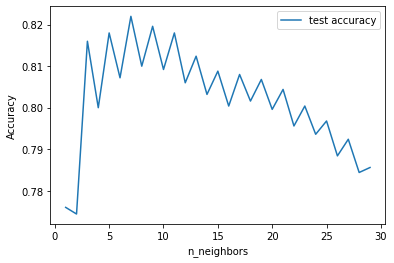

In [ ]:
import matplotlib.pyplot as plt

# hyerparameter tuning
test_accuracy = []
# try n_neighbors from 1 to 30
neighbors_settings = range(1, 30)
for n_neighbors in neighbors_settings:
  # build the model
  clf = KNeighborsClassifier(n_neighbors=n_neighbors)
  #training the model
  clf.fit(X_train, y_train)
  # record training set accuracy
  # record generalization accuracy
  test_accuracy.append(clf.score(X_test, y_test))

plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

# Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# initialize the model
model_log = LogisticRegression()
# training your model on the training datasets -> where the algorithm will learn
model_log = model_log.fit(X_train, y_train)

In [ ]:
print("test data accuracy was ",model_log.score(X_test,y_test))

test data accuracy was  0.9056


In [ ]:
print("train data accuracy was ", model_log.score(X_train, y_train))

train data accuracy was  0.9250666666666667


In [ ]:
pred = model_log.predict(X_test)
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1911
           1       0.74      0.94      0.82       589

    accuracy                           0.91      2500
   macro avg       0.86      0.92      0.88      2500
weighted avg       0.92      0.91      0.91      2500



In [ ]:
confusion_matrix(pred,y_test)

array([[1713,  198],
       [  38,  551]])

# SVM

In [ ]:
from sklearn.svm import LinearSVC

model_svm = LinearSVC()
model_svm.fit(X_train, y_train)

print(model_svm.score(X_train, y_train))
print(model_svm.score(X_test, y_test))

0.9346666666666666
0.902


In [ ]:
pred = model_svm.predict(X_test)
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      1852
           1       0.77      0.89      0.82       648

    accuracy                           0.90      2500
   macro avg       0.86      0.90      0.88      2500
weighted avg       0.91      0.90      0.90      2500



In [ ]:
confusion_matrix(pred,y_test)

array([[1679,  173],
       [  72,  576]])

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
results = cross_validate(model_svm,features_bal, labels_bal, cv = 10)

In [ ]:
results['test_score'].mean()
results['test_score']

array([0.904, 0.887, 0.896, 0.92 , 0.899, 0.921, 0.915, 0.9  , 0.906,
       0.901])

# Naive bayes with test_train_split. My new bigger sample and vectorizer is here(1000 words

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
model_naive = GaussianNB()

In [ ]:
model_naive=model_naive.fit(X_train, y_train)

In [ ]:
pred = model_naive.predict(X_test)

In [ ]:
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

           0       0.41      0.97      0.58      4699
           1       0.91      0.18      0.29      7801

    accuracy                           0.47     12500
   macro avg       0.66      0.57      0.44     12500
weighted avg       0.72      0.47      0.40     12500



In [ ]:
confusion_matrix(pred,y_test)

array([[4560,  139],
       [6428, 1373]])

In [ ]:
#trying on a much bigger sample first with unbalanced dataset

In [ ]:
sample2=final_file_pkl.sample(50000)

In [ ]:
#let's take only the most common 1000 words
bow_vect = CountVectorizer(max_features=1000)
# fit creates one entry for each different word seen  
X = bow_vect.fit_transform(sample2['clean_blob']).toarray()

In [ ]:
bow_vect.fit(sample2['clean_blob'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=1000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
with open("bow_vect","wb") as f:
  pickle.dump(bow_vect,f)

In [ ]:
bow_vect.transform(sample2["clean_blob"]).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
with open("vectorizer","wb") as f:
  pickle.dump(X,f)

In [ ]:
bow_vect.transform(["he ahdfffja alsdkjflka hjfhfhf"]).toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
import pickle

In [ ]:
with open("vectorizer2","wb") as f:
  pickle.dump(bow_vect,f)

In [ ]:
as_df_2=pd.DataFrame(X,columns=bow_vect.get_feature_names())

In [ ]:
vect_feat=bow_vect.get_feature_names()

In [ ]:
with open("vect_feat","wb") as f:
  pickle.dump(vect_feat,f)

In [ ]:
len(vect_feat)

1000

In [ ]:
features2=as_df_2
labels2=sample2["is_offensive"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features2, labels2, random_state=0)

In [ ]:
model_naive_big = GaussianNB()

In [ ]:
model_naive_big=model_naive_big.fit(X_train, y_train)

In [ ]:
print("test data accuracy was ",model_naive_big.score(X_test,y_test))

In [ ]:
pred = model_naive_big.predict(X_test)

In [ ]:
confusion_matrix(pred,y_test)

# Random forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rdm=RandomForestClassifier(n_estimators=100)

In [ ]:
rdm.fit(X_train,y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred=rdm.predict(X_test)

In [ ]:
print("test data accuracy was ",rdm.score(X_test,y_test))

test data accuracy was  0.948


In [ ]:
confusion_matrix(y_pred,y_test)

array([[10801,   463],
       [  187,  1049]])

# Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gb_reg = GradientBoostingClassifier(max_depth=5, #gradient boosting always works with trees, no need to call the tree regressor
                                   n_estimators=100,
                                   random_state=1 # tastes like chicken
                                   )

In [ ]:
gb_reg_fit=gb_reg.fit(X_train, y_train)

In [ ]:
gb_reg.score(X_test,y_test)

0.95224

In [ ]:
y_pred=gb_reg.predict(X_test)

In [ ]:
confusion_matrix(y_pred,y_test)

array([[10898,   507],
       [   90,  1005]])

In [ ]:
with open("model_gradient","wb") as f:
  pickle.dump(gb_reg,f)

# XGBOOST

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred=xgb_clf.predict(X_test)

In [ ]:
xgb_clf.score(X_test,y_test)

0.94656

In [ ]:
confusion_matrix(y_pred,y_test)

array([[10961,   641],
       [   27,   871]])

# Naive bayes with only offensive words on old nltk method

In [ ]:
off_only=final_file_pkl[final_file_pkl["is_offensive"]==1]

In [ ]:
off_only.shape

(8497, 10)

In [ ]:
X = bow_vect.fit_transform(off_only['clean_blob']).toarray()

In [ ]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
word = [word for lis in off_only["no_stopwords"] for word in lis]

frq_off = nltk.FreqDist(word)

top100=[tu for tu in frq_off.most_common(100) ]

In [ ]:
top100

In [ ]:
def find_features_100(lis):
    features= {}
    lis=set(lis)
    
    for w in lis:
        features[w] = (w in top100)
        
    return features

In [ ]:
documents = list(zip(final_file['no_stopwords'], np.where(final_file['is_offensive'] == 1, True, False)))

feature_sets = [(find_features_100(rev), category) for (rev, category) in documents]

In [ ]:
training_set= feature_sets[:65000]
test_set = feature_sets[65000:]
classifier = nltk.NaiveBayesClassifier.train(training_set)
classifier.show_most_informative_features()

Most Informative Features
                  stupid = False            True : False  =    592.3 : 1.0
                    fuck = False            True : False  =    489.3 : 1.0
                    shit = False            True : False  =    279.5 : 1.0
                   bitch = False            True : False  =    272.3 : 1.0
                 asshole = False            True : False  =    225.0 : 1.0
                   pussy = False            True : False  =    195.7 : 1.0
                   nigga = False            True : False  =    183.4 : 1.0
                    dumb = False            True : False  =    145.4 : 1.0
                   idiot = False            True : False  =    108.9 : 1.0
                  shitty = False            True : False  =    106.0 : 1.0


In [ ]:
nltk.classify.accuracy(classifier, test_set)

0.9033956304290602

In [ ]:
test_set[0]

({'mention': False,
  'notch': False,
  'sarileruneekevvaru': False,
  'special': False,
  'top': False,
  'visuals': False},
 False)

In [ ]:
from nltk.metrics import ConfusionMatrix

cm = ConfusionMatrix(test_set)

TypeError: ignored

In [ ]:
classifier.classify({'campaign': False, 'commercial': False, 'cut': False})

False

In [ ]:
train_set_off = feature_sets[:20000]
devtest_set_off = feature_sets[5000:20000]
test_set_off = feature_sets[:5000]

In [ ]:
classifier_off = nltk.NaiveBayesClassifier.train(train_set_off)

In [ ]:
print(nltk.classify.accuracy(classifier, devtest_set_off))

0.9134


In [ ]:
errors = []
for (words, pos) in devtest_set_off:
  guess = classifier_off.classify(words)
  if guess != pos:
    errors.append( (pos, guess) )

In [ ]:
devtest_set_off[0]

({'already': False,
  'market': False,
  'see': False,
  'st': False,
  'version': False},
 False)

In [ ]:
errors[0:5]

[(False, True), (False, True), (False, True), (False, True), (False, True)]

In [ ]:

def conf_matrix(l):
  false_pos=0
  false_neg=0
  for x in l:
    x=list(x)      
    if (x[0]==False) & (x[1]==True):
      false_pos+=1
    elif (x[0]==True) & (x[1]==False):
      false_neg+=1
  return false_pos,false_neg    


In [ ]:
conf_matrix(errors)

(2021, 84)

In [ ]:
errors[0]

(False, True)

In [ ]:
#---------------------------------------------sucks ass----------------------------------------------